In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# eigene Module
from src.dataimport import list_files,list_files_with_extension_directory, load_text
from src.eda import calculate_txt_file_lengths, count_entities, load_ann_files

# Dateien laden

In [2]:
# Example usage
RAW_FILES_PATH = 'data/original/'
TRANSFORMED_FILES_PATH = 'data/transformed/'
list_files(TRANSFORMED_FILES_PATH)[:7]

['essay001.ann',
 'essay001.json',
 'essay002.ann',
 'essay002.json',
 'essay003.ann',
 'essay003.json',
 'essay004.ann']

In [ ]:
files_directory_txt = list_files_with_extension_directory(RAW_FILES_PATH, '.txt')
files_directory_ann = list_files_with_extension_directory(RAW_FILES_PATH, '.ann')
files_directory_json = list_files_with_extension_directory(TRANSFORMED_FILES_PATH, '.json')
# Erste 5 Einträge anzeigen
print(files_directory_txt[0:5])	
print(files_directory_ann[0:5])
print(files_directory_json[0:5])

['data/original/essay001.txt', 'data/original/essay002.txt', 'data/original/essay003.txt', 'data/original/essay004.txt', 'data/original/essay005.txt']
['data/original/essay001.ann', 'data/original/essay002.ann', 'data/original/essay003.ann', 'data/original/essay004.ann', 'data/original/essay005.ann']
['data/transformed/essay001.json', 'data/transformed/essay002.json', 'data/transformed/essay003.json', 'data/transformed/essay004.json', 'data/transformed/essay005.json']


In [23]:
print(len(files_directory_txt))
print(len(files_directory_ann))
print(len(files_directory_json))

402
402
402


# Analyse der Essays (TXT-Dateien)

In [5]:
# Beispieltext laden    
text = load_text(files_directory_txt[0])
print(text)

Should students be taught to compete or to cooperate?

It is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that we should attach more importance to cooperation during primary education.
First of all, through cooperation, children can learn about interpersonal skills which are significant in the future life of all students. What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others. During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think compr

In [6]:
# Texte laden und Anzahl an Wörtern, Zeichen und Tokens berechnen
model_id = "gpt-4o-mini-2024-07-18"

txt_lengths_df = calculate_txt_file_lengths(files_directory_txt, model_id)
txt_lengths_df.sample(5, random_state=42)

,FileName,txt,CharCount,WordCount,TokenCount_txt
285,essay286.txt,Experiences that have shaped your outlook and ...,1949,365,410
281,essay282.txt,Best ways of reducing stress: listening to mus...,2067,376,440
33,essay034.txt,Study at school or get a job?\n\nMany people b...,1822,308,344
211,essay212.txt,Follow the New Customs of the New Country or N...,2290,393,459
93,essay094.txt,Prevention is better than cure\n\nIt is a comp...,2019,323,366


In [7]:
#Duplikate
duplicate_files = txt_lengths_df[txt_lengths_df.duplicated(subset=['txt'], keep=False)][['FileName', 'txt']]
duplicate_files

,FileName,txt
170,essay171.txt,A greater proportion of the budget should be a...
208,essay209.txt,University education restriction\n\nUniverstiy...
209,essay210.txt,A greater proportion of the budget should be a...
376,essay377.txt,University education restriction\n\nUniverstiy...
399,essay400.txt,A greater proportion of the budget should be a...


In [8]:
duplicate_files_list = duplicate_files['FileName'].tolist()
duplicate_files_list

['essay171.txt',
 'essay209.txt',
 'essay210.txt',
 'essay377.txt',
 'essay400.txt']

In [9]:
# Enfernen von Duplikaten
txt_lengths_df = txt_lengths_df.drop_duplicates(subset=['txt'], keep='first')
# statische Analyse
txt_lengths_df.describe()

,CharCount,WordCount,TokenCount_txt
count,399.000000,399.000000,399.000000
mean,1976.060150,327.558897,372.300752
std,321.514548,56.229885,63.479825
min,1243.000000,199.000000,225.000000
25%,1766.000000,289.500000,326.000000
50%,1941.000000,319.000000,362.000000
75%,2175.500000,359.000000,408.500000
max,2847.000000,504.000000,564.000000


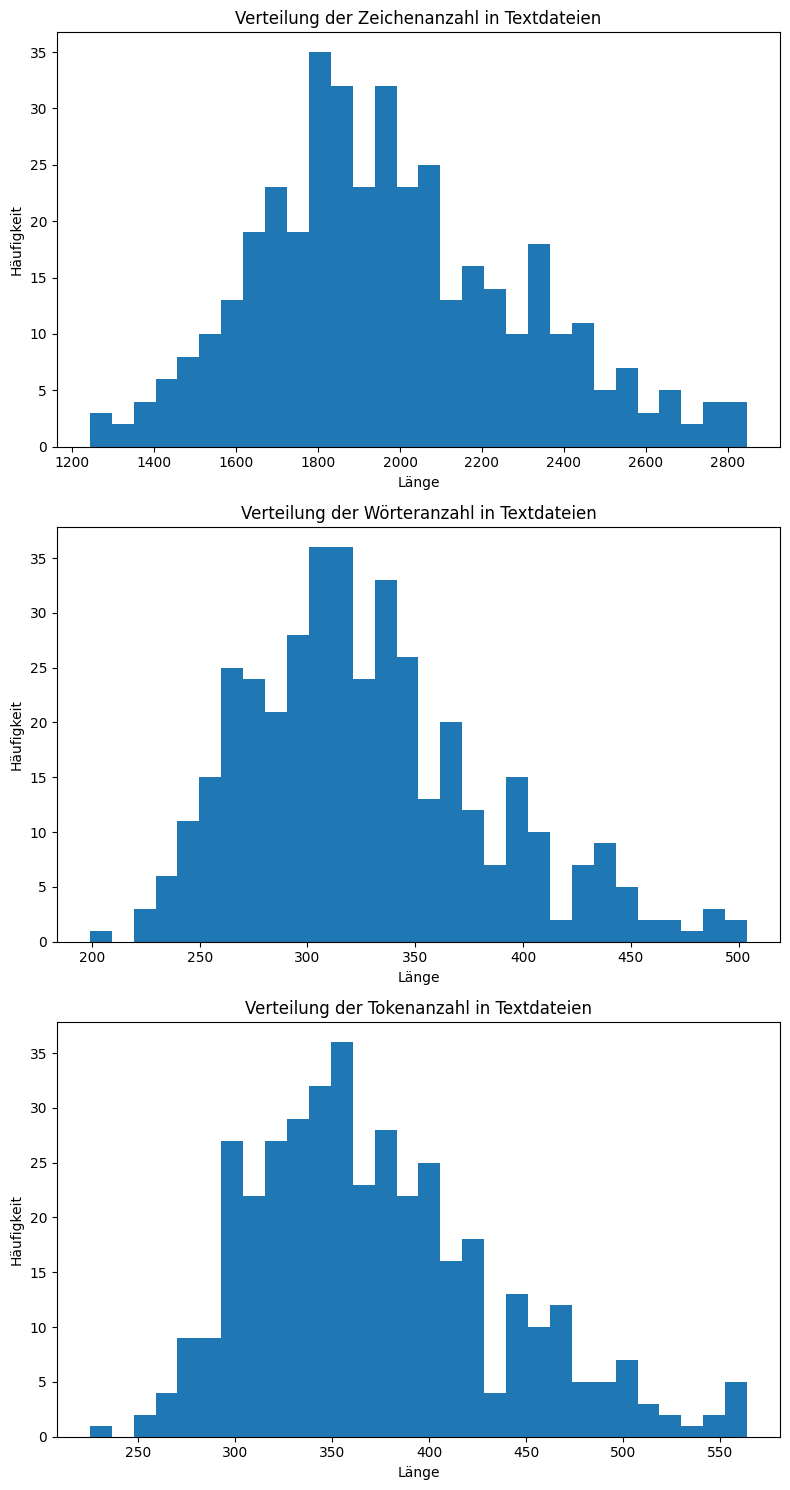

In [10]:
# Verteilung in Textdateien
fig, axs = plt.subplots(3, 1, figsize=(8, 15))

# Verteilung der Zeichenanzahl
axs[0].hist(txt_lengths_df['CharCount'], bins=30)
axs[0].set_title('Verteilung der Zeichenanzahl in Textdateien')
axs[0].set_xlabel('Länge')
axs[0].set_ylabel('Häufigkeit')

# Verteilung der Wortanzahl
axs[1].hist(txt_lengths_df['WordCount'], bins=30)
axs[1].set_title('Verteilung der Wörteranzahl in Textdateien')
axs[1].set_xlabel('Länge')
axs[1].set_ylabel('Häufigkeit')

# Verteilung der Tokenanzahl
axs[2].hist(txt_lengths_df['TokenCount_txt'], bins=30)
axs[2].set_title('Verteilung der Tokenanzahl in Textdateien')
axs[2].set_xlabel('Länge')
axs[2].set_ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

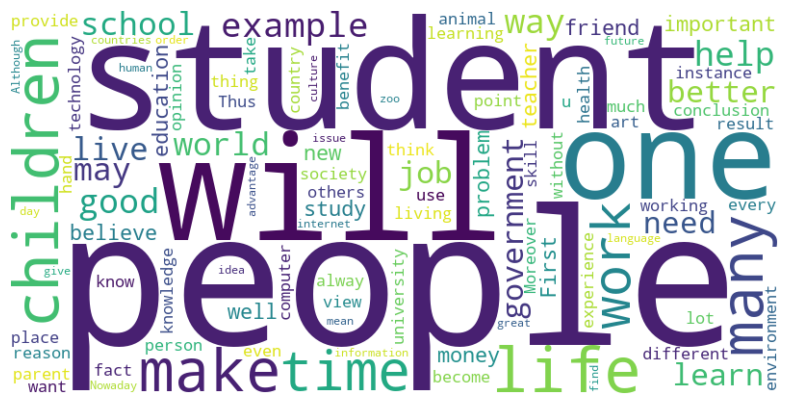

In [11]:
# Kombinieren aller Textdateien zu einem einzigen String
all_text = ''
for file_path in files_directory_txt:
    with open(file_path, 'r') as file:
        all_text += file.read() + ' '
# Stoppwörter
stopwords = set(STOPWORDS)
# eventuelle eigene Stoppwörter hinzufügen
# stopwords.update(['word1','word2'])

# Wortwolke erzeugen
wordcloud = WordCloud(width=800,
                      height=400,
                      stopwords=stopwords,
                      background_color='white',
                      max_words=100, # Standard: 200
                      random_state=42
                      ).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') # bilineare Interpolation, um das angezeigte Bild glatter erscheinen zu lassen
plt.axis('off')
# plt.title('Wortwolke für Textdateien')
plt.show()

# Speichern in Datei
# wordcloud.to_file('wordcloud.png')

# Wordcloud nach Anleitung aus Datacamp erstellt: https://www.datacamp.com/tutorial/wordcloud-python

# Analyse der Annotationen (ANN-Dateien )

In [12]:
#Beispiel für ANN-Datei
print(load_text(files_directory_ann[0]))

T1	MajorClaim 503 575	we should attach more importance to cooperation during primary education
T2	MajorClaim 2154 2231	a more cooperative attitudes towards life is more profitable in one's success
T3	Claim 591 714	through cooperation, children can learn about interpersonal skills which are significant in the future life of all students
A1	Stance T3 For
T4	Premise 716 851	What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others
T5	Premise 853 1086	During the process of cooperation, children can learn about how to listen to opinions of others, how to communicate with others, how to think comprehensively, and even how to compromise with other team members when conflicts occurred
T6	Premise 1088 1191	All of these skills help them to get on well with other people and will benefit them for the whole life
R1	supports Arg1:T4 Arg2:T3	
R2	supports Arg1:T5 Arg2:T3	
R3	supports Arg1:T6 Arg2:T3	
T7	Claim 1332 1376	compe

In [13]:
# Laden der .ann-Dateien
ann_files_df = load_ann_files(files_directory_ann)
ann_files_df.head()

,FileName,Content
0,essay001.ann,T1\tMajorClaim 503 575\twe should attach more ...
1,essay002.ann,T1\tMajorClaim 391 489\tthey are able to susta...
2,essay003.ann,T1\tMajorClaim 352 475\tit has contributed to ...
3,essay004.ann,T1\tMajorClaim 262 376\tthis industry has affe...
4,essay005.ann,T1\tMajorClaim 286 359\tone who studies overse...


In [14]:
# Überprüfung auf Duplikate - wenn der DF leer ist, gibt es keine Duplikate
duplicate_ann_files = ann_files_df[ann_files_df.duplicated(subset=['Content'], keep=False)]
duplicate_ann_files

,FileName,Content


In [15]:
# Anzahl MajorClaims, Claims, Premissen und Beziehungen zählen
count_df = count_entities(files_directory_ann, model_id)

# sort the files by the number of entities
count_df = count_df.sort_values(by=['Total'], ascending=False)
count_df.head()

,FileName,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann
168,essay169.ann,2,6,20,26,54,1044
160,essay161.ann,2,8,16,24,50,980
153,essay154.ann,2,6,18,24,50,987
285,essay286.ann,2,5,18,23,48,913
311,essay312.ann,2,4,19,23,48,886


In [16]:
count_df.describe()

,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,1.868159,3.746269,9.532338,13.278607,28.425373,593.925373
std,0.452239,1.158423,3.405321,3.847724,7.780701,140.771067
min,1.000000,2.000000,2.000000,5.000000,12.000000,291.000000
25%,2.000000,3.000000,7.000000,10.000000,22.000000,491.000000
50%,2.000000,4.000000,9.000000,13.000000,28.000000,578.500000
75%,2.000000,4.000000,12.000000,16.000000,34.000000,691.000000
max,3.000000,10.000000,20.000000,26.000000,54.000000,1044.000000


In [17]:
# Summe der Argumentationskomponenten und Beziehungen
count_df[['MajorClaims','Claims', 'Premises', 'Relations']].sum()

MajorClaims     751
Claims         1506
Premises       3832
Relations      5338
dtype: int64

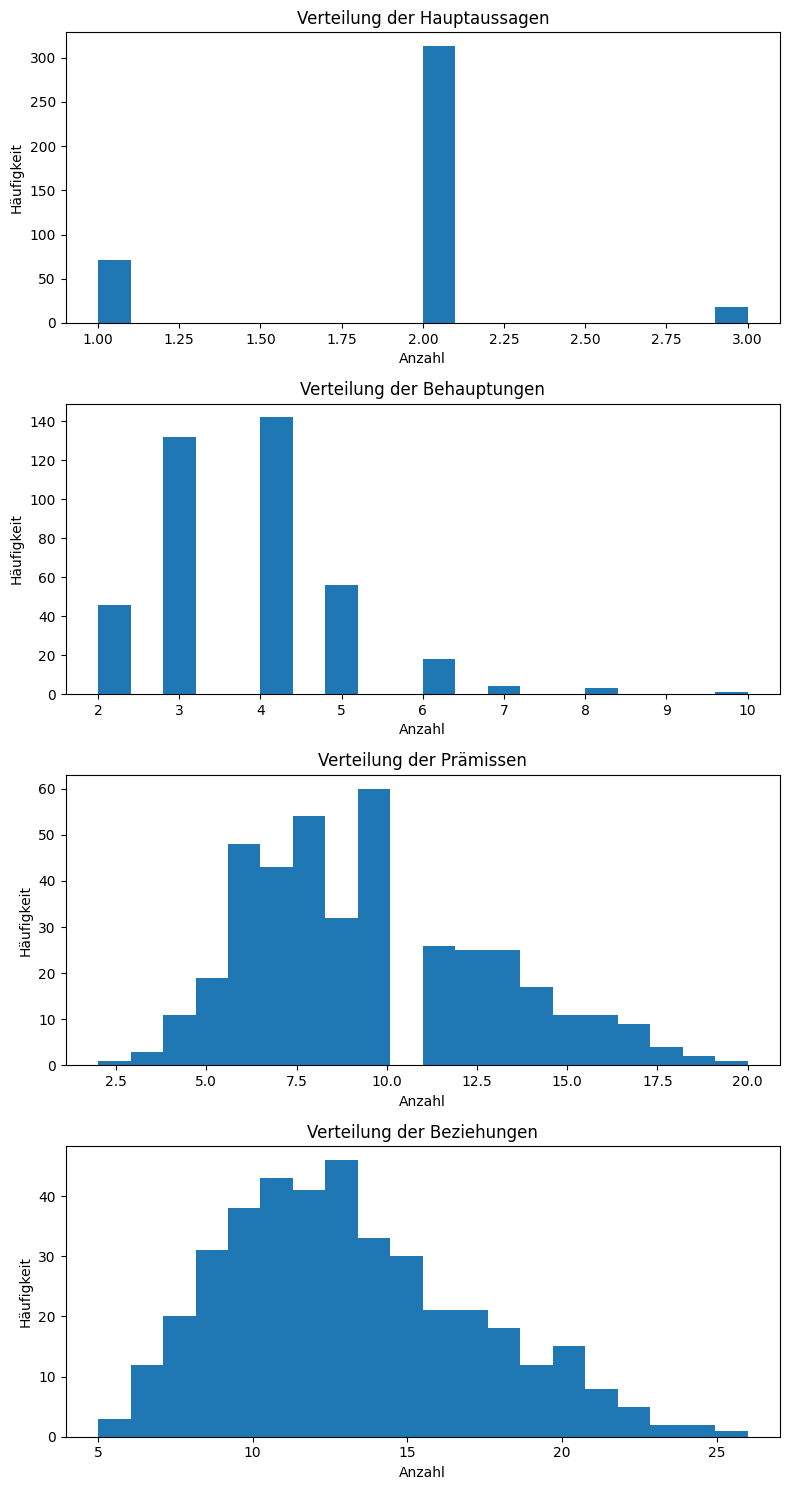

In [18]:
# Verteilung der Anzahl der Entitäten in den Textdateien
fig, axs = plt.subplots(4, 1, figsize=(8, 15))

# Verteilung der MajorClaims
axs[0].hist(count_df['MajorClaims'], bins=20)
axs[0].set_title('Verteilung der Hauptaussagen')
axs[0].set_xlabel('Anzahl')
axs[0].set_ylabel('Häufigkeit')

# Verteilung der Claims
axs[1].hist(count_df['Claims'], bins=20)
axs[1].set_title('Verteilung der Behauptungen')
axs[1].set_xlabel('Anzahl')
axs[1].set_ylabel('Häufigkeit')

# Verteilung der Premises
axs[2].hist(count_df['Premises'], bins=20)
axs[2].set_title('Verteilung der Prämissen')
axs[2].set_xlabel('Anzahl')
axs[2].set_ylabel('Häufigkeit')

# Verteilung der Relations
axs[3].hist(count_df['Relations'], bins=20)
axs[3].set_title('Verteilung der Beziehungen')
axs[3].set_xlabel('Anzahl')
axs[3].set_ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

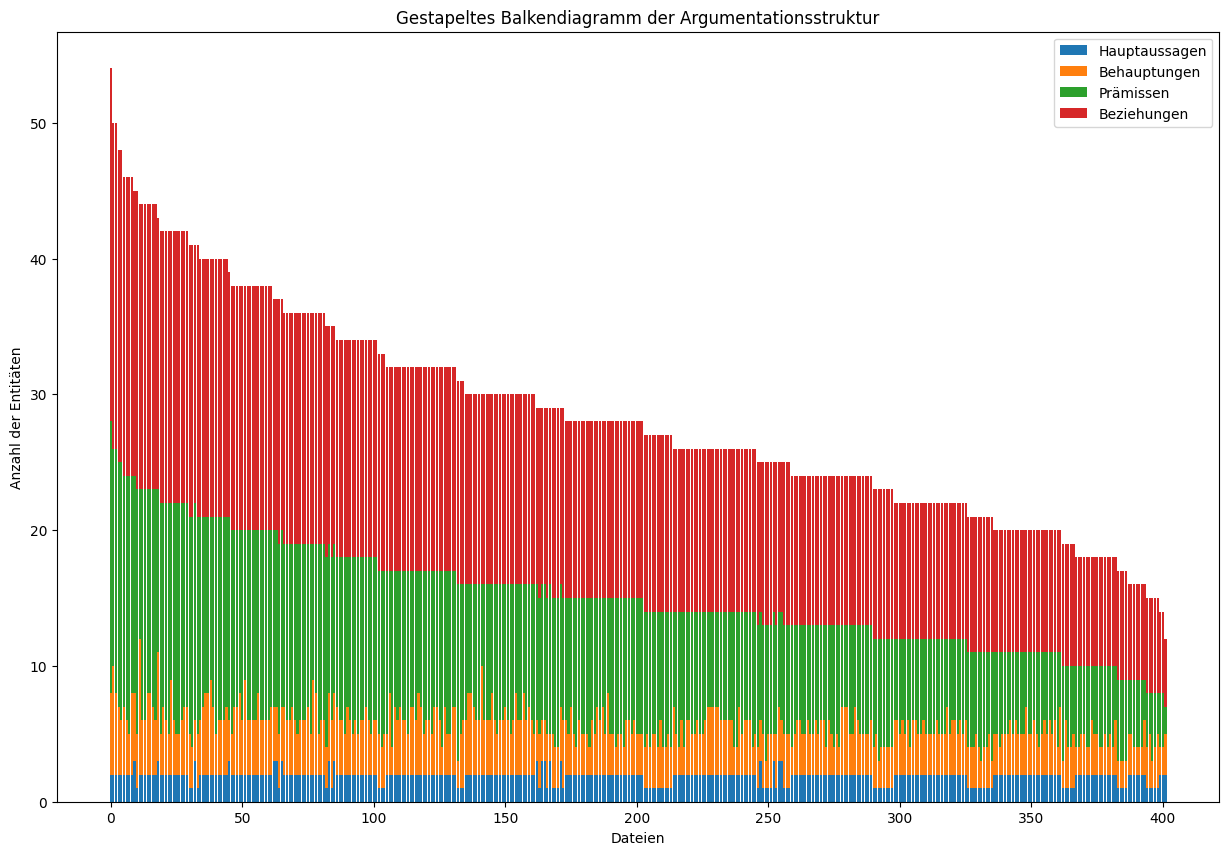

In [19]:
# Gestapeltes Balkendiagramm für die Anzahl der Entitäten in jeder Datei plotten
fig, ax = plt.subplots(figsize=(15, 10))

barWidth = 1
r = range(len(count_df))

mc_count = count_df['MajorClaims']
c_count = count_df['Claims']
p_count = count_df['Premises']
r_count = count_df['Relations']

plt.bar(r, mc_count, label='Hauptaussagen')
plt.bar(r, c_count, bottom=mc_count, label='Behauptungen')
plt.bar(r, p_count, bottom=mc_count + c_count, label='Prämissen')
plt.bar(r, r_count, bottom=mc_count + c_count + p_count, label='Beziehungen')
plt.legend()
plt.xlabel('Dateien')
plt.ylabel('Anzahl der Entitäten')
plt.title('Gestapeltes Balkendiagramm der Argumentationsstruktur')
plt.show()

# Essays with annotations (TXT- und ANN-Dateien)

In [20]:
# Kombinieren der Text- und Annotations-Datenrahmen anhand des Dateinamens ohne Erweiterung
txt_lengths_df.loc[:, 'FileName'] = txt_lengths_df['FileName'].str.replace('.txt', '')
count_df.loc[:, 'FileName'] = count_df['FileName'].str.replace('.ann', '')

combined_df = pd.merge(left=txt_lengths_df, right=count_df, on='FileName')
combined_df['TokenCount_sum'] = combined_df['TokenCount_txt'] + combined_df['TokenCount_ann']
combined_df.sample(5, random_state=42)

,FileName,txt,CharCount,WordCount,TokenCount_txt,MajorClaims,Claims,Premises,Relations,Total,TokenCount_ann,TokenCount_sum
198,essay199,Some students prefer to study alone\n\nEveryon...,1460,262,298,2,4,7,11,24,444,742
349,essay351,Factor of choosing a career.\n\nIn many societ...,1513,245,288,2,4,4,8,18,404,692
33,essay034,Study at school or get a job?\n\nMany people b...,1822,308,344,2,3,12,15,32,624,968
208,essay209,University education restriction\n\nUniverstiy...,1530,251,297,2,3,5,8,18,393,690
93,essay094,Prevention is better than cure\n\nIt is a comp...,2019,323,366,2,3,12,15,32,698,1064


In [21]:
combined_df[['TokenCount_txt', 'TokenCount_ann', 'TokenCount_sum']].describe()

,TokenCount_txt,TokenCount_ann,TokenCount_sum
count,399.000000,399.000000,399.000000
mean,372.300752,595.145363,967.446115
std,63.479825,140.588529,193.250408
min,225.000000,291.000000,554.000000
25%,326.000000,491.000000,822.500000
50%,362.000000,579.000000,947.000000
75%,408.500000,692.500000,1091.000000
max,564.000000,1044.000000,1506.000000
